In [48]:
# Initial imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns
import sqlite3
import geopandas as gpd
from helpers import *

### Load Dataset

In [49]:
# Can query directly from database, or read .csv from repo if not building the database locally
conn = sqlite3.connect("../database/data.db")
df = pd.read_sql_query('''
SELECT
  geo.county AS county,
  name,
  ifnull(1000.0*prov_count / population, 0) AS prov_density,
  ifnull(prov_count, 0) AS prov_count,
  1.0 * population / land_sq_mi AS pop_density,
  land_sq_mi,
  lat,
  lon,
  pct_civ_uninsured,
  pct_veterans,
  avg_household_size,
  pct_household_w_minors,
  pct_female_head_single_mom,
  pct_single_unit_housing,
  pct_multi_unit_housing,
  pct_home_owners,
  pct_labor_participation,
  pct_unemployment,
  population,
  median_age,
  pct_male,
  pct_white,
  pct_black,
  pct_native,
  pct_asian,
  pct_hawaii_pac,
  pct_hisp_latino,
  pct_other_lang_good_eng,
  pct_other_lang_poor_eng,
  pct_married,
  pct_highest_ed_lt_hs,
  pct_highest_ed_hs,
  pct_highest_ed_bach,
  pct_highest_ed_grad_prof,
  median_income,
  pct_poverty,
  pct_citizenship,
  pct_under_5_yr + pct_5_to_17_yr AS pct_lt_18_yr,
  pct_65_to_74_yr + pct_gt_75_yr AS pct_gt_65_yr,
  pct_with_disability
FROM geo LEFT OUTER JOIN
  (SELECT county, COUNT(npi) as prov_count
   FROM nppes
   GROUP BY county) AS grp_npi ON geo.county = grp_npi.county;''', conn)
conn.close()

In [50]:
# Alternatively, read data from .csv. Uncomment if not using sqlite database directly.
# df = pd.read_csv('../../data/data.csv')

In [51]:
# Normalize county FIPS codes and preview table
# Log transform requires adding non-existent small density counties with 0
df['county'] = df['county'].apply(lambda x: str(x).zfill(5))
df['lg_prov_density'] = np.log(df['prov_density'].values + 0.01)
df['prov_shortage'] = (df['prov_density'] < 1/9000).astype(int)
df.head()

,county,name,prov_density,prov_count,pop_density,land_sq_mi,lat,lon,pct_civ_uninsured,pct_veterans,...,pct_highest_ed_bach,pct_highest_ed_grad_prof,median_income,pct_poverty,pct_citizenship,pct_lt_18_yr,pct_gt_65_yr,pct_with_disability,lg_prov_density,prov_shortage
0,01001,"Autauga County, Alabama",0.036340,2,92.583216,594.449,32.532237,-86.646440,8.8,12.6,...,14.5,10.5,28185.0,13.7,3.6,24.5,14.2,18.8,-3.071753,0
1,01003,"Baldwin County, Alabama",0.393391,80,127.914093,1589.817,30.659218,-87.746067,10.8,11.9,...,20.4,10.3,27231.0,11.8,5.0,22.2,19.1,13.7,-0.907849,0
2,01005,"Barbour County, Alabama",0.038166,1,29.605583,885.002,31.870253,-85.405104,12.3,8.0,...,7.6,4.4,17184.0,27.2,3.9,21.1,17.4,22.1,-3.033092,0
3,01007,"Bibb County, Alabama",0.132861,3,36.275365,622.461,33.015893,-87.127148,8.1,7.4,...,8.1,5.1,22650.0,15.2,6.4,21.0,15.1,15.9,-1.945884,0
4,01009,"Blount County, Alabama",0.034682,2,89.431020,644.821,33.977358,-86.566440,11.0,9.6,...,8.7,4.4,25823.0,15.6,5.8,23.6,17.4,14.7,-3.108187,0


In [52]:
# There is one missing value for % single mom head of household
impute = str(df.loc[df['pct_female_head_single_mom'] != '',:]['pct_female_head_single_mom'].median())
df['pct_female_head_single_mom'] = df['pct_female_head_single_mom'].apply(lambda x: x if x != '' else impute)
df['pct_female_head_single_mom'] = df['pct_female_head_single_mom'].astype(float)

### Explore County Level Provider Distributions

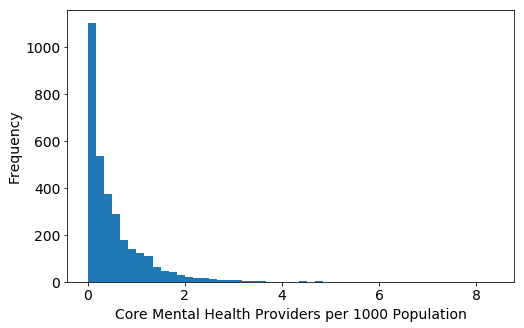

In [53]:
# The distribution is roughly exponential, with many counties having very few providers.
df['prov_density'].plot.hist(bins=50, figsize=(8,5))
plt.xlabel('Core Mental Health Providers per 1000 Population')
plt.show()

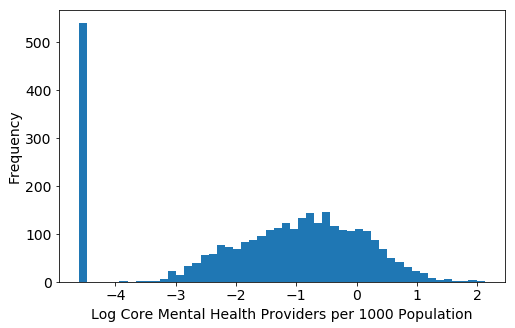

In [54]:
# Applying a log transform still leaves second mode for adjusted "0"
df['lg_prov_density'].plot.hist(bins=50, figsize=(8,5))
plt.xlabel('Log Core Mental Health Providers per 1000 Population')
plt.show()

In [55]:
# Check proportion of provider shortages using the Health Resources and Services Administration 
# threshold of < 1/9000 population (for typical areas, some have higher needs)
df['prov_shortage'].value_counts()

0    2602
1     540
Name: prov_shortage, dtype: int64

This does appear to be a rather high number. The NPPES database is a secondary data source for this analysis application, so it should be noted that there are limitations to these aggregated statistics. For example, some providers are covered under group identifiers, which had to be discarded from the database
because the group identifiers are opaque to the number and taxonomy of the 
covered indvidual providers. 

It will be interesting to eventually check my results against the latest reports on shortage areas from HRSA. 

See the paper below for some discussion of issues with using NPI data for workforce studies:

"Kaplan, Louise, et al. "Understanding APRN distribution in the United States using NPI data." The Journal for Nurse Practitioners 8.8 (2012): 626-635."

Next, I will explore provider density and binary shortage areas across the US. 

In [56]:
# Load in county shape files
county_path = "../../data/county_shapes/cb_2017_us_county_500k.shp"
county_df = gpd.read_file(county_path)

# For now, will filter down to contiguous US
county_df = county_df.cx[-130:-60,20:55]

In [57]:
# Join features of interest to map df
map_features = ['prov_density', 'lg_prov_density', 'prov_count', 'population', 'prov_shortage', 'county', 'lat', 'lon']
county_df = county_df.set_index('GEOID').join(df.loc[:,map_features].set_index('county'))

# Cap provider density for the sake of linear visualization
county_df['cap_prov_density'] = county_df['prov_density'].apply(lambda x: min(1,x))

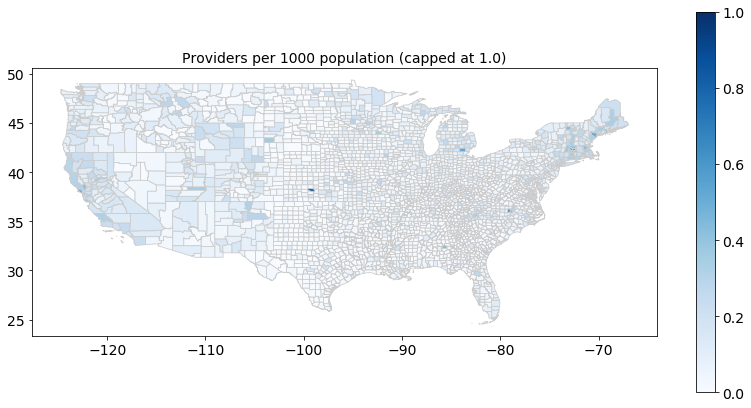

In [58]:
# Create choropleth of provider density

min_val = county_df['cap_prov_density'].min()
max_val = county_df['cap_prov_density'].max()

width = 14
height = (55-20)/(130-60) * width
fig, ax = plt.subplots(1,1,figsize=(width, height))

county_df.plot(column='prov_density', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('on')
ax.set_title('Providers per 1000 population (capped at 1.0)', fontdict={'fontsize': '14'})

# Create colorbar as a legend
leg = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min_val,
                                                             vmax=max_val))
leg._A = []
cbar = fig.colorbar(leg)

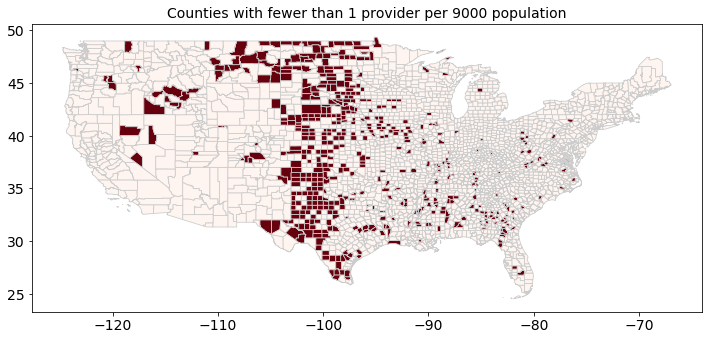

In [59]:
# Create choropleth of shortage areas

width = 12
height = (55-20)/(130-60) * width
fig, ax = plt.subplots(1,1,figsize=(width, height))

county_df.plot(column='prov_shortage', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('on')
ax.set_title('Counties with fewer than 1 provider per 9000 population', fontdict={'fontsize': '14'})
plt.show()

This is interesting, but it is also clear there is a lot of variance at the county level. I will next see what the trends look like at a state level, and whether states can be grouped into regions.

### Explore State Level Distributions and Regional Partitioning

In [60]:
state_agg = county_df.groupby(['STATEFP'], as_index=False).agg(dict(lat = 'mean', 
                                                                    lon = 'mean',
                                                                    prov_count = 'sum',
                                                                    population = 'sum'))
state_agg['prov_density'] = state_agg['prov_count'] / state_agg['population']
state_agg['prov_shortage'] = (state_agg['prov_density'] < 1/9000).astype(int) 

In [61]:
# Load in county shape files
state_path = "../../data/state_shapes/cb_2017_us_state_500k.shp"
state_df = gpd.read_file(state_path)

# For now, will filter down to contiguous US
state_df = state_df.cx[-130:-60,20:55]

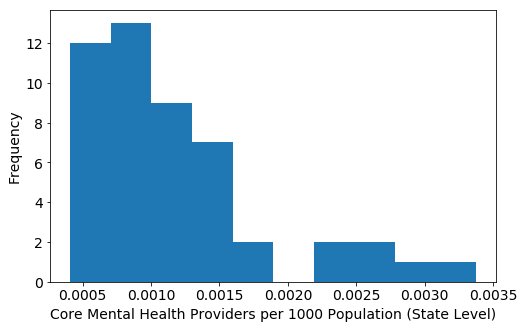

In [62]:
# The distribution is still skewed right, but less extreme (as expected)
state_agg['prov_density'].plot.hist(figsize=(8,5))
plt.xlabel('Core Mental Health Providers per 1000 Population (State Level)')
plt.show()

In [63]:
# Check proportion of provider shortages using the Health Resources and Services Administration 
# threshold of < 1/9000 population
state_agg['prov_shortage'].value_counts()

0    49
Name: prov_shortage, dtype: int64

Once aggregated at a state level, there are no provider shortages in terms of a simple provider/population ratio. Defining the correct area of aggregation for these statistics is tricky. At a high enough level, the distribution is "smoothed out", obscuring some patterns. At too low of a level, there is high variance. Also, at lower levels such as tracts there is the issue of mapping population to provider locations (e.g. one tract may have some large hospitals/clinics, while an adjacent tract is all residental homes - averaging at a tract level will give the appearance that the former has a high provider density while the later is a shortage. Yet, it is very reasonable to expect that patients can easily travel to the next neighborhood for care).

Counties provide a nice middle-ground, and are also preferable to zip codes as county level governments have some influence over health services while zip codes are an arbitrary "secondary" geography defined for the use of the postal service.

In [64]:
# Join features of interest to map df
state_df = state_df.set_index('STATEFP').join(state_agg.set_index('STATEFP'))

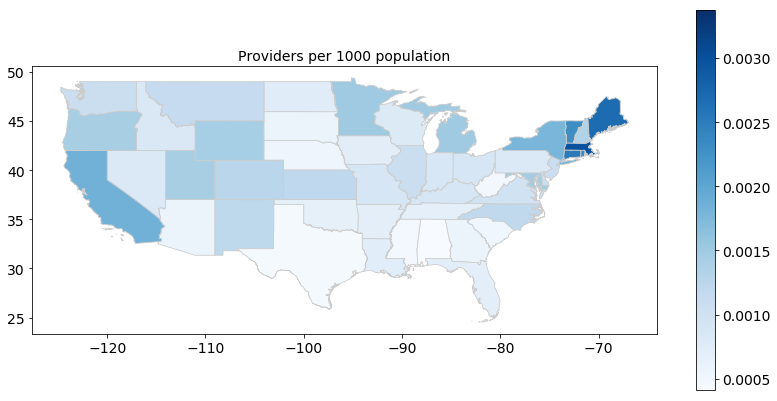

In [65]:
# Create choropleth of provider density

min_val = state_df['prov_density'].min()
max_val = state_df['prov_density'].max()

width = 14
height = (55-20)/(130-60) * width
fig, ax = plt.subplots(1,1,figsize=(width, height))

state_df.plot(column='prov_density', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('on')
ax.set_title('Providers per 1000 population', fontdict={'fontsize': '14'})

# Create colorbar as a legend
leg = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min_val,
                                                             vmax=max_val))
leg._A = []
cbar = fig.colorbar(leg)

In general, the West Coast and Northeast have higher provider densities. The South has lower density in general. 

I am interested in analyzing counties both at a regional and national level. I will try using a shallow decision tree to partition the US into natural regions based on state-level provider density. A decision tree works well for this, as it will make nested cuts along latitude and longitude values to produce contiguous groups at its leaves.

In [66]:
# I will run a grid search over shallow decision trees and let cross-validation on MSE select the regions
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
params = {'max_depth': [1,2,3,4,5], 'min_samples_leaf': [1,5,10]}
dt_gs = GridSearchCV(DecisionTreeRegressor(), params, cv=10)
dt_gs.fit(state_df.loc[:,['lat','lon']].values, state_df['prov_density'].values)
print(f'Best params: {dt_gs.best_params_}, Best score (DT): {dt_gs.best_score_}')
dummy_score = np.mean(cross_val_score(DummyRegressor(), state_df.loc[:,['lat','lon']].values,
                                      state_df['prov_density'].values, cv=10))
print(f'Best score (dummy): {dummy_score}')

Best params: {'max_depth': 5, 'min_samples_leaf': 5}, Best score (DT): -0.05035613009074365
Best score (dummy): -0.8408447447236711


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


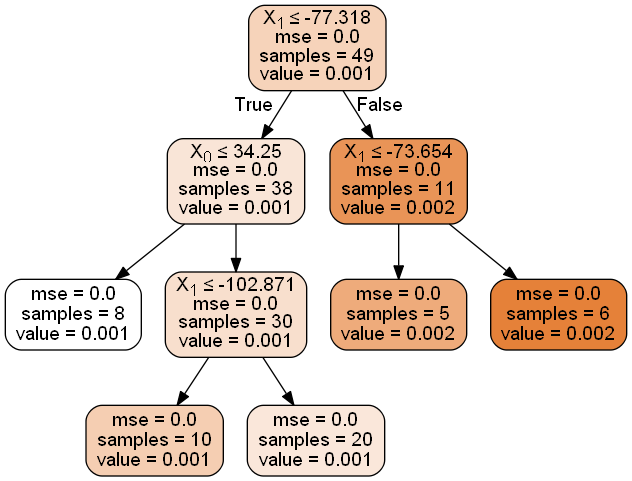

In [67]:
# Citation for plotting code below: 
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_gs.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The decision tree above shows "greedy" selection of nested latitude/longitude cuts that most reduce variance. $X_0$ is latitude and $X_1$ is longitude. For example, the first cut is at -77.318 deg longitude, which effectively separates the Northeast US as a region. In the next level, the southern US and a second region near the Northeast is separated. 

In [68]:
# Now, let's see what regions the decision tree has identified
state_df['predict'] = dt_gs.best_estimator_.predict(state_df.loc[:,['lat','lon']].values)
leaf_map = state_df['predict'].to_dict()

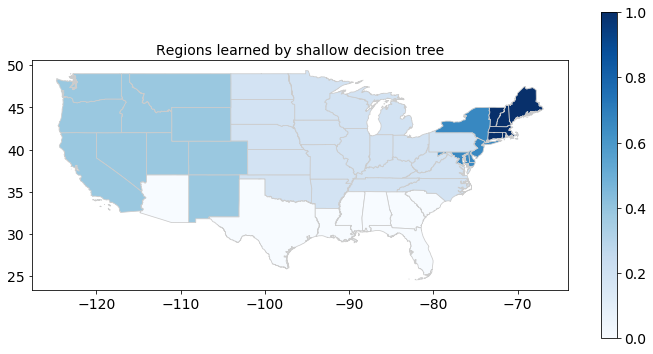

In [69]:
# Create choropleth showing how lat-long splits US
fig, ax = plt.subplots(1, figsize=(12, 6))
state_df.plot(column='predict', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('on')
ax.set_title('Regions learned by shallow decision tree', fontdict={'fontsize': '14'})

# Create colorbar as a legend
leg = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
leg._A = []
cbar = fig.colorbar(leg)

The end objective is to be able to compare the provider density in a county to potential associations with other variables (e.g. income, racial demographics, education levels) and with respect to how a county ranks in those variables relative to counties within the same region or across the US as a whole. 

### Check correlation matrix, run PCA at national level

I will next remove unneeded columns and standardize the data. 

In [70]:
df.drop(['county', 'name', 'prov_count', 'land_sq_mi',
         'population', 'lg_prov_density'], inplace=True, axis=1)
data, y, clf_y, feat_cols = df.values[:,1:-1], df.values[:,0], df.values[:,-1], df.columns[1:-1]

In [71]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std_data = ss.fit_transform(data) 

Next, I'll see which variables are most correlated with provider density (note I am taking abs(), so sign is removed).  

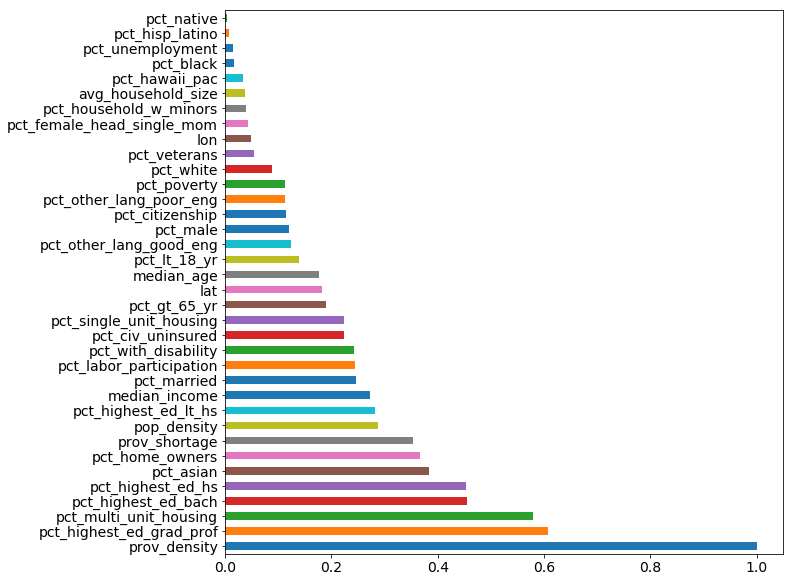

In [72]:
# Make this a barplot instead
df.corr()['prov_density'].apply(abs).sort_values(ascending=False).plot(kind='barh', figsize=(10,10))
plt.show()

I am sorting on absolute values, so this is only showing magnitude, not direction, of each relationship. The two most correlated features are % graduate/professional degrees and % multiple unit housing. After that, other education levels, and a mixture of other factors are associated. I will plot the most correlated features together in a correlation coefficient heatmap.  

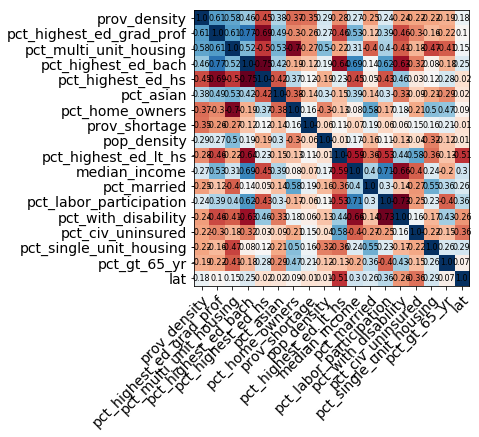

In [73]:
select_cols = df.corr()['prov_density'].apply(abs).sort_values(ascending=False)[:18].index.tolist()
df_select = df.loc[:,select_cols]
heat_map(df_select.corr().values, df_select.columns, df_select.columns, figsize=(10,10), sort_f=False)

As expected, there is significant multicollinearity between the most correlated features. For example, the two most correlated predictors "% graduate/professional degrees" and "% multiple unit housing" have a linear correlation coefficient of 0.61. In addition, "% highest education high school" has a strong negative correlation with "% graduate/professional degrees". I could point out many other samples like these. 

This multicollinearity becomes problematic when trying to fit linear models to the data. Regularization can be used to penalize redundant features when prediction is the only objective. However, regularization will shrink or even eliminate features in a fitted model in a way that can provide an abitrarily distorted view of feature importance. I will illustrate this below by fitting two regularized linear models and a Random Forest regressor and comparing the resulting feature importance measures. 

In [74]:
# First, fit models and compare cv MSE scores to a dummy (mean) regressor to ensure that the features are predictive
# I will fit the models to predict the log(provider density) due to the exponential shape of the original distribution
# The dummy model and unregularized linear regression have no hyperparameters to tune, and Ridge and Lasso regression
# have efficient auto-tuning classes in sklearn. However, I will use GridSearchCV for the convenience of having
# training scores as well.
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

train_scores = []
cv_scores = []

# Dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
dummy_gs = GridSearchCV(dummy_reg, {'strategy': ['mean']}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
dummy_gs.fit(std_data, y)
train_scores.append(dummy_gs.cv_results_['mean_train_score'][dummy_gs.best_index_])
cv_scores.append(dummy_gs.best_score_)

# Linear regression (unregularized)
lin_reg = LinearRegression()
lin_gs = GridSearchCV(lin_reg, {'fit_intercept': [True]}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
lin_gs.fit(std_data, y)
train_scores.append(lin_gs.cv_results_['mean_train_score'][lin_gs.best_index_])
cv_scores.append(lin_gs.best_score_)

# Ridge regression (regularized)
ridge_reg = Ridge()
ridge_gs = GridSearchCV(ridge_reg, {'alpha': np.logspace(-4,6,22)}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
ridge_gs.fit(std_data, y)
train_scores.append(ridge_gs.cv_results_['mean_train_score'][ridge_gs.best_index_])
cv_scores.append(ridge_gs.best_score_)

# Lasso regression (regularized)
lasso_reg = Lasso()
lasso_gs = GridSearchCV(lasso_reg, {'alpha': np.logspace(-4,6,22)}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
lasso_gs.fit(std_data, y)
train_scores.append(lasso_gs.cv_results_['mean_train_score'][lasso_gs.best_index_])
cv_scores.append(lasso_gs.best_score_)

# Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_gs = GridSearchCV(rf_reg, {'n_estimators': [50, 100, 250, 500, 1000]}, scoring='neg_mean_squared_error', n_jobs=4,
                     cv=10, return_train_score=True)
rf_gs.fit(std_data, y)
train_scores.append(rf_gs.cv_results_['mean_train_score'][rf_gs.best_index_])
cv_scores.append(rf_gs.best_score_)

# Gradient Boosting Trees Regressor
gb_reg = GradientBoostingRegressor()
gb_gs = GridSearchCV(gb_reg, {'n_estimators': [50, 100, 250, 500, 1000]}, scoring='neg_mean_squared_error', n_jobs=4,
                     cv=10, return_train_score=True)
gb_gs.fit(std_data, y)
train_scores.append(gb_gs.cv_results_['mean_train_score'][gb_gs.best_index_])
cv_scores.append(gb_gs.best_score_)

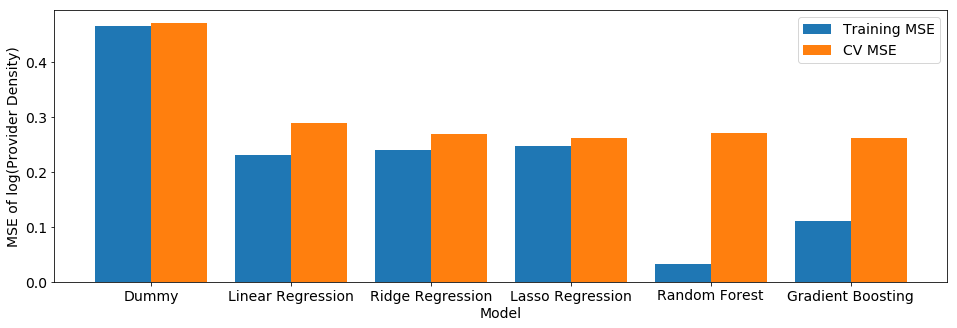

In [75]:
# Plot training and cross-validation MSE scores
train_scores = np.array(train_scores)
cv_scores = np.array(cv_scores)

tick_labels = ['Dummy', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting']

fig, ax = plt.subplots(figsize=(16,5))
width=0.4
indices = np.linspace(0,5,6)
ax.bar(indices, -1*train_scores, width=width, tick_label=tick_labels, label='Training MSE')
ax.bar(indices + width, -1*cv_scores, width=width, tick_label=tick_labels, label='CV MSE')
ax.set_xticks(indices + width / 2)
ax.set_xlabel('Model')
ax.set_ylabel('MSE of log(Provider Density)')
ax.legend()
plt.show()

In [76]:
std_feat_imp = {'lin_reg': np.abs(lin_gs.best_estimator_.coef_),
            'ridge_reg': np.abs(ridge_gs.best_estimator_.coef_),
            'lasso_reg': np.abs(lasso_gs.best_estimator_.coef_),
            'rf_reg': np.abs(rf_gs.best_estimator_.feature_importances_)}
std_feat_imp_df = pd.DataFrame(std_feat_imp, index=feat_cols)
std_feat_imp_df.sort_values('lin_reg', ascending=True, inplace=True)

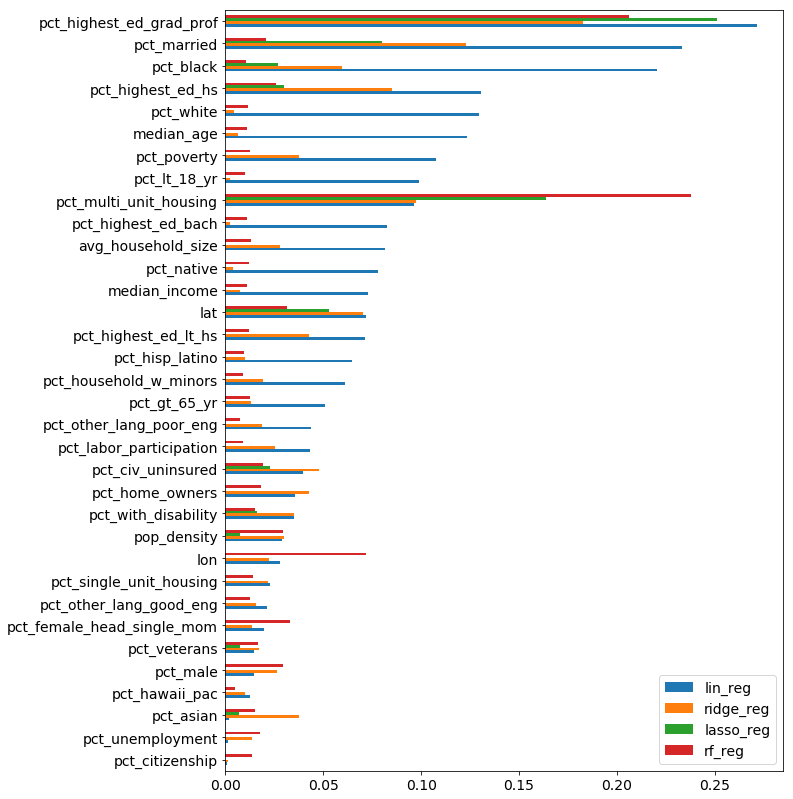

In [77]:
std_feat_imp_df.plot(kind='barh', figsize=(10,14))
plt.show()

In [78]:
# Transform data using PCA
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(std_data)

In [79]:
# Fit PCA on uncorrelated scrambling of the data (null comparison)
uncorr_std_data = np.array(std_data)
for i in range(uncorr_std_data.shape[1]):
        np.random.shuffle(uncorr_std_data[:,i])
pca_uncorr = PCA()
pca_uncorr_data = pca_uncorr.fit_transform(uncorr_std_data)

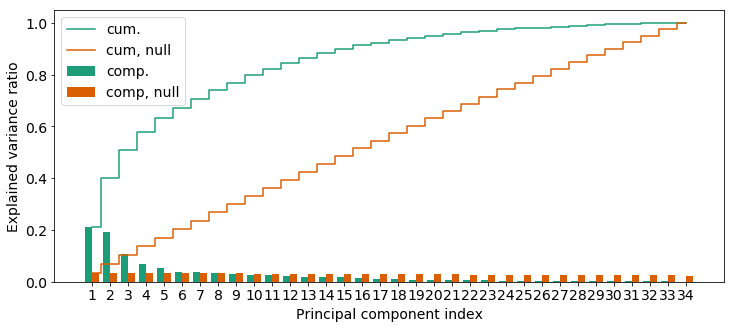

In [80]:
# Plot variance explained per component
variance_explained_plot(pca, pca_uncorr, figsize=(12,5))

The first two principal components cover about 40% of the overall variance. This indicates there is much multicollinenarity. I will see what these first two principal components represent. 

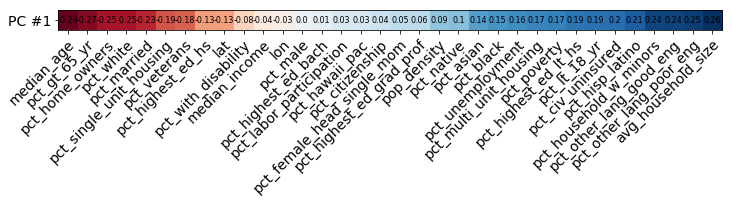

In [81]:
# Show composition of first pc as a heatmap
heat_map(pca.components_[:1], feat_cols, ['PC #1'], figsize=(12,12))

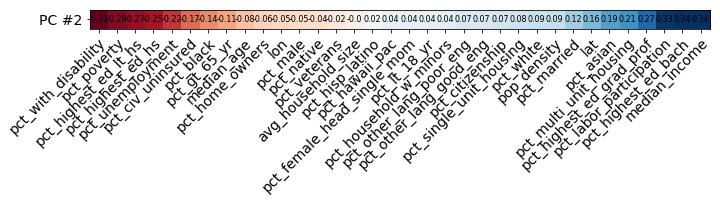

In [82]:
# Show composition of second pc as a heatmap
heat_map(pca.components_[1:2], feat_cols, ['PC #2'], figsize=(12,12))

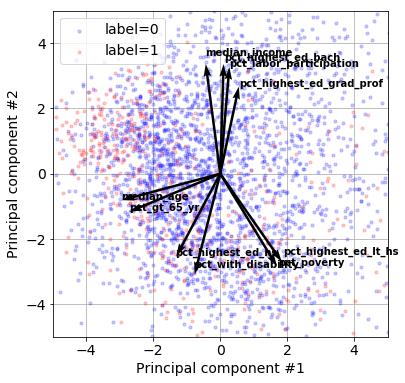

In [83]:
# Plot counties in 2D PCA space, color by shortage areas
pca_2d_plot(pca_data, clf_y, pca=pca, xlim=(-5,5), ylim=(-5,5),
                features=feat_cols, plot_num_features=10, figsize=(6,6))

In [84]:
# Refit models using PCA transformed data

train_scores = []
cv_scores = []

# Dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
dummy_gs = GridSearchCV(dummy_reg, {'strategy': ['mean']}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
dummy_gs.fit(pca_data, y)
train_scores.append(dummy_gs.cv_results_['mean_train_score'][dummy_gs.best_index_])
cv_scores.append(dummy_gs.best_score_)

# Linear regression (unregularized)
lin_reg = LinearRegression()
lin_gs = GridSearchCV(lin_reg, {'fit_intercept': [True]}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
lin_gs.fit(pca_data, y)
train_scores.append(lin_gs.cv_results_['mean_train_score'][lin_gs.best_index_])
cv_scores.append(lin_gs.best_score_)

# Ridge regression (regularized)
ridge_reg = Ridge()
ridge_gs = GridSearchCV(ridge_reg, {'alpha': np.logspace(-4,6,22)}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
ridge_gs.fit(pca_data, y)
train_scores.append(ridge_gs.cv_results_['mean_train_score'][ridge_gs.best_index_])
cv_scores.append(ridge_gs.best_score_)

# Lasso regression (regularized)
lasso_reg = Lasso()
lasso_gs = GridSearchCV(lasso_reg, {'alpha': np.logspace(-4,6,22)}, scoring='neg_mean_squared_error', n_jobs=4,
                        cv=10, return_train_score=True)
lasso_gs.fit(pca_data, y)
train_scores.append(lasso_gs.cv_results_['mean_train_score'][lasso_gs.best_index_])
cv_scores.append(lasso_gs.best_score_)

# Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_gs = GridSearchCV(rf_reg, {'n_estimators': [50, 100, 250, 500, 1000]}, scoring='neg_mean_squared_error', n_jobs=4,
                     cv=10, return_train_score=True)
rf_gs.fit(pca_data, y)
train_scores.append(rf_gs.cv_results_['mean_train_score'][rf_gs.best_index_])
cv_scores.append(rf_gs.best_score_)

# Gradient Boosting Trees Regressor
gb_reg = GradientBoostingRegressor()
gb_gs = GridSearchCV(gb_reg, {'n_estimators': [50, 100, 250, 500, 1000]}, scoring='neg_mean_squared_error', n_jobs=4,
                     cv=10, return_train_score=True)
gb_gs.fit(pca_data, y)
train_scores.append(gb_gs.cv_results_['mean_train_score'][gb_gs.best_index_])
cv_scores.append(gb_gs.best_score_)

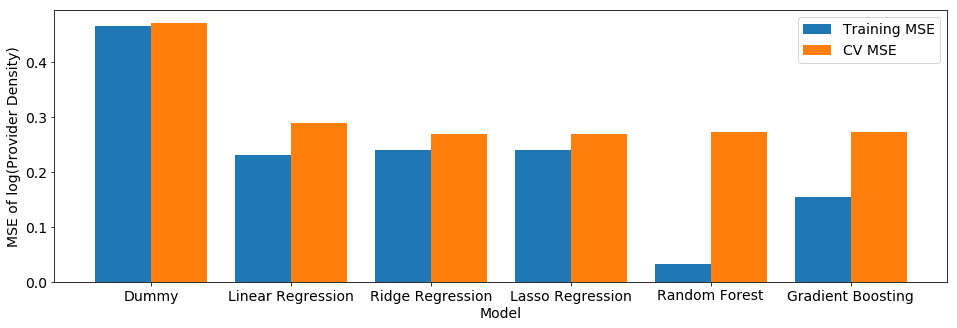

In [85]:
# Plot training and cross-validation MSE scores
train_scores = np.array(train_scores)
cv_scores = np.array(cv_scores)

tick_labels = ['Dummy', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting']

fig, ax = plt.subplots(figsize=(16,5))
width=0.4
indices = np.linspace(0,5,6)
ax.bar(indices, -1*train_scores, width=width, tick_label=tick_labels, label='Training MSE')
ax.bar(indices + width, -1*cv_scores, width=width, tick_label=tick_labels, label='CV MSE')
ax.set_xticks(indices + width / 2)
ax.set_xlabel('Model')
ax.set_ylabel('MSE of log(Provider Density)')
ax.legend()
plt.show()

In [86]:
pca_feat_imp = {'lin_reg': np.abs(lin_gs.best_estimator_.coef_),
                'ridge_reg': np.abs(ridge_gs.best_estimator_.coef_),
                'lasso_reg': np.abs(lasso_gs.best_estimator_.coef_),
                'rf_reg': np.abs(rf_gs.best_estimator_.feature_importances_)}
pca_feat_imp_df = pd.DataFrame(pca_feat_imp, index=['PC #' + str(i) for i in range(len(feat_cols))])
pca_feat_imp_df.sort_values('lin_reg', ascending=True, inplace=True)

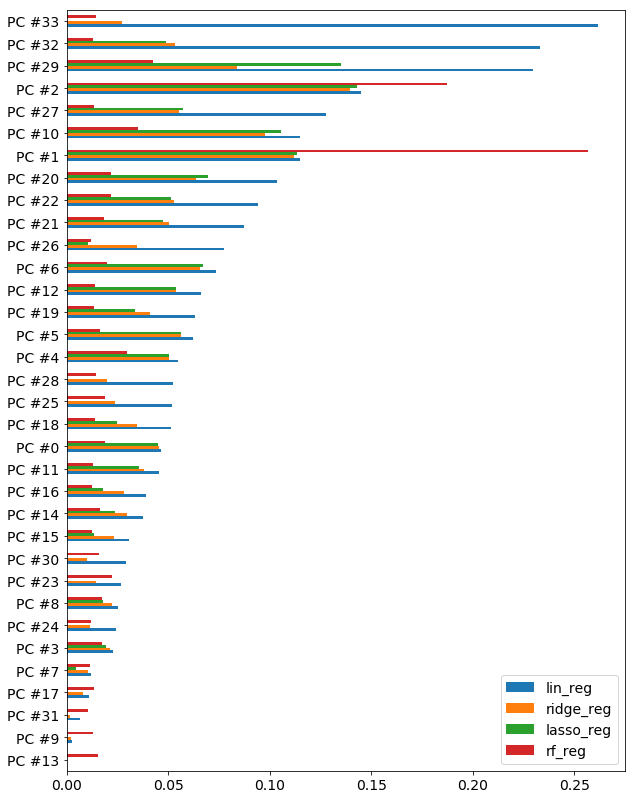

In [87]:
pca_feat_imp_df.plot(kind='barh', figsize=(10,14))
plt.show()

The figures show the expected outcome from PCA. The feature importance ranking for the regulairzed linear models become more consistent, while random forest still has a very different feature importance ranking. The later is expected, given that a random forest can learn more general nonlinear relationships between features and the response. I will also look at Pearson's correlation coefficient between the coefficients. 

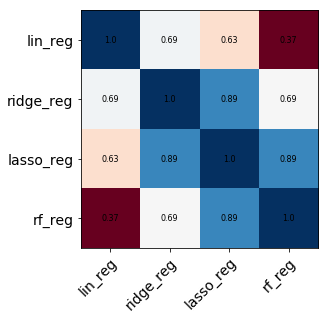

In [88]:
heat_map(std_feat_imp_df.corr().values, std_feat_imp_df.columns, std_feat_imp_df.columns, figsize=(5,5), sort_f=False)

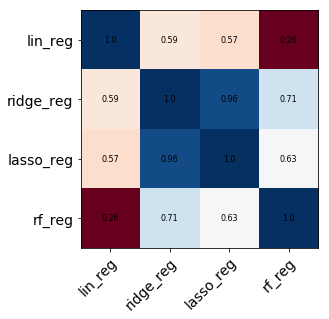

In [89]:
heat_map(pca_feat_imp_df.corr().values, pca_feat_imp_df.columns, pca_feat_imp_df.columns, figsize=(5,5), sort_f=False)

As expected, the correlation between the coefficients of the two regularized linear models has improved from 0.89 to a very high 0.96. The main difference between the two is that Lasso completely zero's out the least predictive variables, as expected.

This analysis is a work in progress. I still need to run bootstraps on the regularized linear model coefficients before/after PCA to illustrate the improvement in stability and work through the rest of the analysis including fitting linear models to the various regions learned by the decision tree.